<a href="https://colab.research.google.com/github/chekfung/cross_layer_final_project/blob/main/training_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Source Code

## Imports Needed Throughout the Project

In [1]:
# All Imports 
import sys
import numpy as np
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from google.colab import files

# argument parser
import easydict

## Get and Download Datasets

In [2]:
# MNIST Dataset (Images and Labels)
train_set = dsets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

test_set = dsets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



## FP32 Model 

In [3]:
class MyConvNet_FP32(nn.Module):
    def __init__(self, args):
        super(MyConvNet_FP32, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        self.act1  = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        self.act2  = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Layer 3
        self.lin2  = nn.Linear(7*7*32, 10)

    def forward(self, x):
        # Layer 1
        c1 = self.conv1(x)
        b1  = self.bn1(c1)
        a1  = self.act1(b1)
        p1  = self.pool1(a1)

        # Layer 2
        c2  = self.conv2(p1)
        b2  = self.bn2(c2)
        a2  = self.act2(b2)
        p2  = self.pool2(a2)

        # Flatten and Layer 3
        flt = p2.view(p2.size(0), -1)
        out = self.lin2(flt)
        return out
  
# model = MyConvNet(args)
# model = model.cuda()

## Quantization Helper Code

In [4]:
def simple_quantize_val(val, scale_factor, min_val, max_val):
  value = torch.round(val / scale_factor)

  if (value < min_val):
    value = min_val

  if (value > max_val):
    value = max_val

  return (value * scale_factor)

def fixed_point_quantize_val(val, num_bits, fractional_bits):
  integer_bits = num_bits - fractional_bits - 1 # Subtract one for sign bit
  smallest_step_size = 1 / np.power(2, fractional_bits)
  largest_number = (np.power(2, integer_bits) - 1) + ((np.power(2, fractional_bits)-1) * smallest_step_size)
  smallest_number = -1 * np.power(2, integer_bits)

  value = torch.round(val / smallest_step_size) * smallest_step_size

  if (value < smallest_number):
    value = smallest_number

  if (value > largest_number):
    value = largest_number

  return value

# Perhaps slightly optimized version?
def fixed_point_quantize_faster(val, smallest_step_size, largest_number, smallest_number):

  # Perform Pseudo Quantization
  value = torch.round(val / smallest_step_size) * smallest_step_size

  # Clamp Values
  if (value < smallest_number):
    value = smallest_number

  if (value > largest_number):
    value = largest_number

  return value

### NOTE: ONLY USE THIS SHIT ###
def optimized_tensor_fp_quantize(tens, step_size, largest_num, smallest_num):
  # Do everything in tensor operations
  new_tensor = torch.round(tens / step_size) * step_size
  torch.clamp(new_tensor, min=smallest_num, max=largest_num) 
  return new_tensor

# Right now, only for integer quantization.
def quantize_fp_model_weights(model):
  count = 0
  for layer in model.modules():
    if not isinstance(layer, (nn.ReLU, nn.MaxPool2d)) and count != 0:
        
      with torch.no_grad():
        layer.weight.data = optimized_tensor_fp_quantize(layer.weight.data, model.weights_step_size, model.weights_largest_num_representable, model.weights_smallest_num_representable)

    count += 1
  
  return 0

def quantize_fp_model_biases(model):
  count = 0
  for layer in model.modules():
    if not isinstance(layer, (nn.ReLU, nn.MaxPool2d)) and count != 0:
        
      with torch.no_grad():
        layer.bias.data = optimized_tensor_fp_quantize(layer.bias.data, model.bias_step_size, model.bias_largest_num_representable, model.bias_smallest_num_representable)

    count += 1
  
  return 0

In [5]:
def train_model(arg, model, criterion, optimizer, train_loader, quantize=False):
    print("---Training started")
    # Training the Model
    for epoch in range(arg.epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Load Images into GPU
            images = images.cuda()
            labels = Variable(labels).cuda()

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            L1norm = model.parameters()
            arr = []

            # Calculate L1 Norm (if included in hyperparameters)
            if arg.L1norm == True:
                for name,param in model.named_parameters():
                    if 'weight' in name.split('.'):
                        arr.append(param)

                L1loss = 0
                for Losstmp in arr:
                    L1loss = L1loss+Losstmp.abs().mean()

                if len(arr) > 0:
                    loss = loss+L1loss/len(arr)

            if quantize:
                # quantize loss
                loss.data = optimized_tensor_fp_quantize(loss.data, model.loss_step_size, model.loss_largest_num_representable, model.loss_smallest_num_representable)

            # Optimizer Step, Propagate Loss backwards
            loss.backward()

            if quantize:
              
                # quantize gradients
                for name,param in model.named_parameters():
                    # Print BEFORE Gradients
                    # print(gradient)

                    param.grad.data = optimized_tensor_fp_quantize(param.grad.data, model.gradient_step_size, model.gradient_largest_num_representable, model.gradient_smallest_num_representable)
                    
                    # Print AFTER Gradients
                    # print(gradient)
                
            optimizer.step()

            # # TODO: Need to quantize the biases as well.
            if quantize:
              quantize_fp_model_weights(model)
              quantize_fp_model_biases(model)

            if (i + 1) % 600 == 0:
                print('Epoch: [% d/% d], Step: [% d/% d], Loss: %.4f'
                        % (epoch + 1, arg.epochs, i + 1,
                        len(train_set) // arg.batch_size, loss.data.item()))


# Gets accuracy given dataset as well as total test loss
def get_acc(model, criterion, test_loader, quantized=False):
    correct = 0
    total = 0
    testloss = 0

    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        testloss += criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        break

    if quantized:
      testloss = optimized_tensor_fp_quantize(testloss, model.loss_step_size, model.loss_largest_num_representable, model.loss_smallest_num_representable)

    return ((100 * correct / total), testloss)

## Quantization Model

In [6]:
# Assume that we always 
class MyConvNet_FIXED_POINT(nn.Module):
    def __init__(self, args, forwardfp, gradientfp, lossfp, weightsfp, biasfp): #xfp's are tuples of the # of bits in the fp rep & # of fractional bits
        super(MyConvNet_FIXED_POINT, self).__init__()


        ### gradient FP Parameters ###
        self.gradient_fp_bits = gradientfp[0]
        self.gradient_int_bits = (gradientfp[0] - 1 - gradientfp[1])
        self.gradient_fract_bits = gradientfp[1]
 
        self.gradient_step_size = 1 / np.power(2, gradientfp[1])
        self.gradient_largest_num_representable = (np.power(2, self.gradient_int_bits) - 1) + ((np.power(2, self.gradient_fract_bits)-1) * self.gradient_step_size)
        self.gradient_smallest_num_representable = -1 * np.power(2, self.gradient_int_bits)
        #########################

        ### forward FP Parameters ###
        self.forward_fp_bits = forwardfp[0]
        self.forward_int_bits = (forwardfp[0] - 1 - forwardfp[1])
        self.forward_fract_bits = forwardfp[1]
 
        self.forward_step_size = 1 / np.power(2, forwardfp[1])
        self.forward_largest_num_representable = (np.power(2, self.forward_int_bits) - 1) + ((np.power(2, self.forward_fract_bits)-1) * self.forward_step_size)
        self.forward_smallest_num_representable = -1 * np.power(2, self.forward_int_bits)
        #########################

        ### Loss FP Parameters ###
        self.loss_fp_bits = lossfp[0]
        self.loss_int_bits = (lossfp[0] - 1 - lossfp[1])
        self.loss_fract_bits = lossfp[1]

        self.loss_step_size = 1 / np.power(2, lossfp[1])
        self.loss_largest_num_representable = (np.power(2, self.loss_int_bits) - 1) + ((np.power(2, self.loss_fract_bits)-1) * self.loss_step_size)
        self.loss_smallest_num_representable = -1 * np.power(2, self.loss_int_bits)
        #########################

        ### weights FP Parameters ###
        self.weights_fp_bits = weightsfp[0]
        self.weights_int_bits = (weightsfp[0] - 1 - weightsfp[1])
        self.weights_fract_bits = weightsfp[1]
 
        self.weights_step_size = 1 / np.power(2, weightsfp[1])
        self.weights_largest_num_representable = (np.power(2, self.weights_int_bits) - 1) + ((np.power(2, self.weights_fract_bits)-1) * self.weights_step_size)
        self.weights_smallest_num_representable = -1 * np.power(2, self.weights_int_bits)
        #########################

        ### bias FP Parameters ###
        self.bias_fp_bits = biasfp[0]
        self.bias_int_bits = (biasfp[0] - 1 - biasfp[1])
        self.bias_fract_bits = biasfp[1]
 
        self.bias_step_size = 1 / np.power(2, biasfp[1])
        self.bias_largest_num_representable = (np.power(2, self.bias_int_bits) - 1) + ((np.power(2, self.bias_fract_bits)-1) * self.bias_step_size)
        self.bias_smallest_num_representable = -1 * np.power(2, self.bias_int_bits)
        #########################

        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        self.act1  = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        self.act2  = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Layer 3
        self.lin2  = nn.Linear(7*7*32, 10)

    # AUGMENT FORWARD PASS. forward pass not quantizes every single time we go through
    def forward(self, x):
        xq = optimized_tensor_fp_quantize(x, self.forward_step_size, self.forward_largest_num_representable, self.forward_smallest_num_representable)
        # Layer 1
        c1 = self.conv1(xq)
        c1q = optimized_tensor_fp_quantize(c1, self.forward_step_size, self.forward_largest_num_representable, self.forward_smallest_num_representable)
        b1  = self.bn1(c1q)
        b1q = optimized_tensor_fp_quantize(b1, self.forward_step_size, self.forward_largest_num_representable, self.forward_smallest_num_representable)
        a1  = self.act1(b1q)
        p1  = self.pool1(a1)
 
        # Layer 2
        c2  = self.conv2(p1)
        c2q = optimized_tensor_fp_quantize(c2, self.forward_step_size, self.forward_largest_num_representable, self.forward_smallest_num_representable)
        b2  = self.bn2(c2q)
        b2q = optimized_tensor_fp_quantize(b2, self.forward_step_size, self.forward_largest_num_representable, self.forward_smallest_num_representable)
        a2  = self.act2(b2q)
        p2  = self.pool2(a2)
 
        # Flatten and Layer 3
        flt = p2.view(p2.size(0), -1)
        out = self.lin2(flt)
        out_new = optimized_tensor_fp_quantize(out, self.forward_step_size, self.forward_largest_num_representable, self.forward_smallest_num_representable)
        return out

In [7]:
class QuantizedConvNet(nn.Module):
    def __init__(self, model_fp32):
        super(QuantizedConvNet, self).__init__()
        # QuantStub converts tensors from floating point to quantized.
        # This will only be used for inputs.
        self.quant = torch.quantization.QuantStub()
        # DeQuantStub converts tensors from quantized to floating point.
        # This will only be used for outputs.
        self.dequant = torch.quantization.DeQuantStub()
        # FP32 model
        self.model_fp32 = model_fp32

    def forward(self, x):
        # manually specify where tensors will be converted from floating
        # point to quantized in the quantized model
        x = self.quant(x)
        x = self.model_fp32(x)
        # manually specify where tensors will be converted from quantized
        # to floating point in the quantized model
        x = self.dequant(x)
        return x

# Test Code Here


In [8]:
# Hyper Parameter for FashionMNIST
input_size = 784
num_classes = 10



## Example of instantiating a model, training it with given hyperparameters, etc

In [9]:
args = easydict.EasyDict({
        "batch_size": 32,
        "epochs": 5,
        "lr": 0.001,
        "enable_cuda" : True,
        "L1norm" : False,
        "simpleNet" : True,
        "activation" : "relu", #relu, tanh, sigmoid
        "train_curve" : True, 
        "optimization" :"Adam"
})

# Dataset Loader (Input Pipeline)
quantize = True
train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = args.batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = args.batch_size, shuffle = False)

num_bits_test = [64, 32, 16, 8, 4]
num_fractional_bits = [32, 16, 8, 4, 2]
acc = []

# for (num_bits,num_fractional_bits) in zip(num_bits_test, num_fractional_bits):
#   print(num_bits)
#   print(num_fractional_bits)
#   forwardfp= (num_bits, num_fractional_bits) 
#   gradientfp= (num_bits, num_fractional_bits) 
#   lossfp= (num_bits, num_fractional_bits) 
#   weightsfp= (num_bits, num_fractional_bits) 
#   biasfp=(num_bits, num_fractional_bits) 

#   # Declare Model
#   model = MyConvNet_FIXED_POINT(args, forwardfp, gradientfp, lossfp, weightsfp, biasfp).cuda()
#   #model = MyConvNet_FP32(args).cuda()

#   criterion = nn.CrossEntropyLoss().cuda()
#   optimizer = torch.optim.Adam(model.parameters(), lr = args.lr) 

#   # Training
#   train_model(args, model, criterion, optimizer, train_loader, quantize)

#   # Need to quantize the model afterwards
#   quantize_fp_model_weights(model)

#   # Testing ARC
#   test_acc, test_loss = get_acc(model, criterion, test_loader, quantize)
#   print("Test Accuracy: {}".format(test_acc))
#   print("Test Loss: {}".format(test_loss))

#   acc.append(test_acc.item())

# plt.figure(0)
# plt.plot(num_bits_test, acc)
# plt.title("Varying Number of Quantized Bits")
# plt.xlabel("Number of Quantized Bits")
# plt.ylabel("Acc (%)")
# plt.show()


In [ ]:
# forwardfp= (16, 8) 
# gradientfp= (16, 10) 
# lossfp= (16, 10) 
# weightsfp= (24, 12) 
# biasfp=(16, 8) 

# # Declare Model
# model = MyConvNet_FIXED_POINT(args, forwardfp, gradientfp, lossfp, weightsfp, biasfp).cuda()
# #model = MyConvNet_FP32(args).cuda()

# criterion = nn.CrossEntropyLoss().cuda()
# optimizer = torch.optim.Adam(model.parameters(), lr = args.lr) 

# # Training
# train_model(args, model, criterion, optimizer, train_loader, quantize)

# # Need to quantize the model afterwards
# quantize_fp_model_weights(model)

# # Testing ARC
# test_acc, test_loss = get_acc(model, criterion, test_loader, quantize)
# print("Test Accuracy: {}".format(test_acc))
# print("Test Loss: {}".format(test_loss))


## Running many models! <3

In [10]:
# Default Params
num_bits = [32, 26, 20, 16, 10, 4]
fractional_bits = list(np.linspace(0.3, 0.8, 6))
string_help = ["Forward Quantization", "Gradient Quantization", "Loss Quantization", "Weights Quantization", "Bias Quantization"]
print(num_bits)
print(fractional_bits)

for thing_change in range(3,5):
  acc_list = []
  count = 0

  for fraction in fractional_bits:
    acc = []

    for num_bit in num_bits:
      # Loop through both
      num_fractional_bits = np.floor(fraction * num_bit)

      print("Count: {}".format(count))

      # Default parameters
      forwardfp = (16, 8) 
      gradientfp = (16, 10) 
      lossfp = (16, 10) 
      weightsfp = (24, 12) 
      biasfp = (16, 8) 

      # Declare Model
      if thing_change == 0:
        forwardfp = (num_bit, num_fractional_bits)
        model = MyConvNet_FIXED_POINT(args, forwardfp, gradientfp, lossfp, weightsfp, biasfp).cuda()
      elif thing_change == 1:
        gradientfp = (num_bit, num_fractional_bits)
        model = MyConvNet_FIXED_POINT(args, forwardfp, gradientfp, lossfp, weightsfp, biasfp).cuda()
      elif thing_change == 2:
        lossfp = (num_bit, num_fractional_bits)
        model = MyConvNet_FIXED_POINT(args, forwardfp, gradientfp, lossfp, weightsfp, biasfp).cuda()
      elif thing_change == 3:
        weightsfp = (num_bit, num_fractional_bits)
        model = MyConvNet_FIXED_POINT(args, forwardfp, gradientfp, lossfp, weightsfp, biasfp).cuda()
      elif thing_change == 4:
        biasfp = (num_bit, num_fractional_bits)
        model = MyConvNet_FIXED_POINT(args, forwardfp, gradientfp, lossfp, weightsfp, biasfp).cuda()

      criterion = nn.CrossEntropyLoss().cuda()
      optimizer = torch.optim.Adam(model.parameters(), lr = args.lr) 

      # Training
      train_model(args, model, criterion, optimizer, train_loader, quantize)

      # Need to quantize the model afterwards
      quantize_fp_model_weights(model)
      quantize_fp_model_biases(model)

      # Testing ARC
      test_acc, test_loss = get_acc(model, criterion, test_loader, quantize)
      print("Test Accuracy: {}".format(test_acc))
      print("Test Loss: {}".format(test_loss))
      
      acc.append(test_acc.cpu())
      count+=1
    
    acc_list.append(acc)

  # Cool Stuff
  plt.figure(thing_change)

  for count, acc_item in enumerate(acc_list):
    plt.plot(num_bits, acc_item, label='{:.1f}'.format(fractional_bits[count]))
  
  plt.xlabel("Number of Bits in Quantized Value")
  plt.ylabel("Test Accuracy on FashionMNIST (%)")
  plt.legend()
  plt.title("Varying Number of Bits in " + string_help[thing_change])

plt.show()








[32, 26, 20, 16, 10, 4]
[0.3, 0.4, 0.5, 0.6000000000000001, 0.7, 0.8]
Count: 0
---Training started


KeyboardInterrupt: ignored

## Running FP 32 Model

In [10]:
fp_32model = MyConvNet_FP32(args).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(fp_32model.parameters(), lr = args.lr) 

train_model(args, fp_32model, criterion, optimizer, train_loader, False)

test_acc, test_loss = get_acc(fp_32model, criterion, test_loader, False)
print("Test Accuracy: {}".format(test_acc))
print("Test Loss: {}".format(test_loss))

---Training started
Epoch: [ 1/ 5], Step: [ 600/ 1875], Loss: 0.5007
Epoch: [ 1/ 5], Step: [ 1200/ 1875], Loss: 0.4434
Epoch: [ 1/ 5], Step: [ 1800/ 1875], Loss: 0.1536
Epoch: [ 2/ 5], Step: [ 600/ 1875], Loss: 0.3590
Epoch: [ 2/ 5], Step: [ 1200/ 1875], Loss: 0.1106
Epoch: [ 2/ 5], Step: [ 1800/ 1875], Loss: 0.2324
Epoch: [ 3/ 5], Step: [ 600/ 1875], Loss: 0.3567
Epoch: [ 3/ 5], Step: [ 1200/ 1875], Loss: 0.2382
Epoch: [ 3/ 5], Step: [ 1800/ 1875], Loss: 0.1503
Epoch: [ 4/ 5], Step: [ 600/ 1875], Loss: 0.0969
Epoch: [ 4/ 5], Step: [ 1200/ 1875], Loss: 0.2320
Epoch: [ 4/ 5], Step: [ 1800/ 1875], Loss: 0.1920
Epoch: [ 5/ 5], Step: [ 600/ 1875], Loss: 0.1093
Epoch: [ 5/ 5], Step: [ 1200/ 1875], Loss: 0.2528
Epoch: [ 5/ 5], Step: [ 1800/ 1875], Loss: 0.3301
Test Accuracy: 93.75
Test Loss: 0.46279460191726685


## Hopefully FP Optimized Model?

In [10]:
args = easydict.EasyDict({
        "batch_size": 32,
        "epochs": 5,
        "lr": 0.001,
        "enable_cuda" : True,
        "L1norm" : False,
        "simpleNet" : True,
        "activation" : "relu", #relu, tanh, sigmoid
        "train_curve" : True, 
        "optimization" :"Adam"
})

# Dataset Loader (Input Pipeline)
quantize = True
train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = args.batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = args.batch_size, shuffle = False)

forwardfp = (16, 4) 
gradientfp = (16, 9) 
lossfp = (16, 11) 
weightsfp = (16, 11) 
biasfp = (10, 8) 

# Declare Model
model = MyConvNet_FIXED_POINT(args, forwardfp, gradientfp, lossfp, weightsfp, biasfp).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = args.lr) 
criterion = nn.CrossEntropyLoss().cuda()

# Training
train_model(args, model, criterion, optimizer, train_loader, quantize)

# Need to quantize the model afterwards
quantize_fp_model_weights(model)
quantize_fp_model_biases(model)

# Testing ARC
test_acc, test_loss = get_acc(model, criterion, test_loader, quantize)
print(test_loss)
print(float(test_loss.data.cpu()))
print("Test Accuracy: {}".format(test_acc))
print("Test Loss: {}".format(test_loss))

---Training started
Epoch: [ 1/ 5], Step: [ 600/ 1875], Loss: 0.2773
Epoch: [ 1/ 5], Step: [ 1200/ 1875], Loss: 0.3638
Epoch: [ 1/ 5], Step: [ 1800/ 1875], Loss: 0.4028
Epoch: [ 2/ 5], Step: [ 600/ 1875], Loss: 0.1904
Epoch: [ 2/ 5], Step: [ 1200/ 1875], Loss: 0.3594
Epoch: [ 2/ 5], Step: [ 1800/ 1875], Loss: 0.2358
Epoch: [ 3/ 5], Step: [ 600/ 1875], Loss: 0.4517
Epoch: [ 3/ 5], Step: [ 1200/ 1875], Loss: 0.1362
Epoch: [ 3/ 5], Step: [ 1800/ 1875], Loss: 0.3257
Epoch: [ 4/ 5], Step: [ 600/ 1875], Loss: 0.1938
Epoch: [ 4/ 5], Step: [ 1200/ 1875], Loss: 0.3896
Epoch: [ 4/ 5], Step: [ 1800/ 1875], Loss: 0.3145
Epoch: [ 5/ 5], Step: [ 600/ 1875], Loss: 0.2471
Epoch: [ 5/ 5], Step: [ 1200/ 1875], Loss: 0.1426
Epoch: [ 5/ 5], Step: [ 1800/ 1875], Loss: 0.5874
tensor(0.4097, device='cuda:0', grad_fn=<MulBackward0>)
0.40966796875
Test Accuracy: 84.375
Test Loss: 0.40966796875


## Running Hyperparameters?

---Training started
---Training started
Epoch: [ 1/ 10], Step: [ 600/ 937], Loss: 0.4053
Epoch: [ 2/ 10], Step: [ 600/ 937], Loss: 0.2178
Epoch: [ 3/ 10], Step: [ 600/ 937], Loss: 0.2104
Epoch: [ 4/ 10], Step: [ 600/ 937], Loss: 0.3691
Epoch: [ 5/ 10], Step: [ 600/ 937], Loss: 0.2568
Epoch: [ 6/ 10], Step: [ 600/ 937], Loss: 0.2539
Epoch: [ 7/ 10], Step: [ 600/ 937], Loss: 0.3306
Epoch: [ 8/ 10], Step: [ 600/ 937], Loss: 0.2427
Epoch: [ 9/ 10], Step: [ 600/ 937], Loss: 0.4268
Epoch: [ 10/ 10], Step: [ 600/ 937], Loss: 0.1631
---Training started
Epoch: [ 1/ 10], Step: [ 600/ 1875], Loss: 0.5361
Epoch: [ 1/ 10], Step: [ 1200/ 1875], Loss: 0.2998
Epoch: [ 1/ 10], Step: [ 1800/ 1875], Loss: 0.5112
Epoch: [ 2/ 10], Step: [ 600/ 1875], Loss: 0.4756
Epoch: [ 2/ 10], Step: [ 1200/ 1875], Loss: 0.3374
Epoch: [ 2/ 10], Step: [ 1800/ 1875], Loss: 0.1836
Epoch: [ 3/ 10], Step: [ 600/ 1875], Loss: 0.6987
Epoch: [ 3/ 10], Step: [ 1200/ 1875], Loss: 0.3130
Epoch: [ 3/ 10], Step: [ 1800/ 1875], Loss: 

Text(0.5, 1.0, 'Test Loss Vs. Num Epochs')

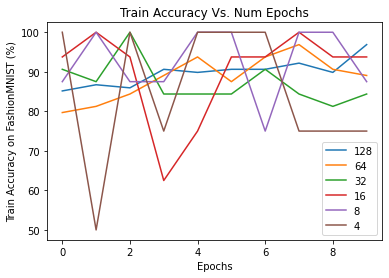

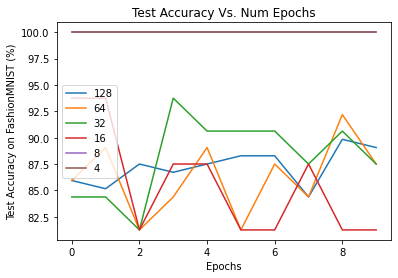

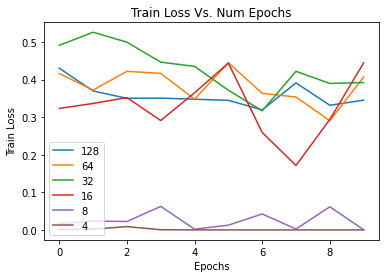

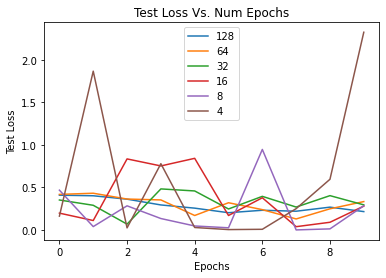

In [25]:
args = easydict.EasyDict({
        "batch_size": 32,
        "epochs": 10,
        "lr": 0.001,
        "enable_cuda" : True,
        "L1norm" : False,
        "simpleNet" : True,
        "activation" : "relu", #relu, tanh, sigmoid
        "train_curve" : True, 
        "optimization" :"Adam"
})

# Dataset Loader (Input Pipeline)
quantize = True

batch_size_list = [128, 64, 32, 16, 8, 4]
train_acc_big_list = []
test_acc_big_list = []
test_loss_big_list = []
train_loss_big_list = []

for count, batch_size in enumerate(batch_size_list):
    args.batch_size = batch_size

    train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = batch_size, shuffle = False)

    forwardfp = (16, 4) 
    gradientfp = (16, 9) 
    lossfp = (16, 11) 
    weightsfp = (16, 11) 
    biasfp = (10, 8) 

    # Declare Model
    model = MyConvNet_FIXED_POINT(args, forwardfp, gradientfp, lossfp, weightsfp, biasfp).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr = args.lr) 
    criterion = nn.CrossEntropyLoss().cuda()

    # Training the Model
    print("---Training started")
    test_acc_list = []
    train_acc_list = []
    test_loss_list = []
    train_loss_list = []

    for epoch in range(args.epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Load Images into GPU
            images = images.cuda()
            labels = Variable(labels).cuda()

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            if quantize:
                # quantize loss
                loss.data = optimized_tensor_fp_quantize(loss.data, model.loss_step_size, model.loss_largest_num_representable, model.loss_smallest_num_representable)

            # Optimizer Step, Propagate Loss backwards
            loss.backward()

            if quantize:
              
                # quantize gradients
                for name,param in model.named_parameters():
                    param.grad.data = optimized_tensor_fp_quantize(param.grad.data, model.gradient_step_size, model.gradient_largest_num_representable, model.gradient_smallest_num_representable)
                
            optimizer.step()

            # # TODO: Need to quantize the biases as well.
            if quantize:
              quantize_fp_model_weights(model)
              quantize_fp_model_biases(model)

            if (i + 1) % 600 == 0:
                print('Epoch: [% d/% d], Step: [% d/% d], Loss: %.4f'
                        % (epoch + 1, args.epochs, i + 1,
                        len(train_set) // args.batch_size, loss.data.item()))
                
        # Get Test ACC and Train ACC
        test_acc, test_loss = get_acc(model, criterion, test_loader, True)
        train_acc, train_loss = get_acc(model, criterion, train_loader, True)

        test_acc_list.append(test_acc.cpu())
        train_acc_list.append(train_acc.cpu())

        test_loss_list.append(float(test_loss.data.cpu()))
        train_loss_list.append(float(train_loss.data.cpu()))

    # Out of Epochs
    train_acc_big_list.append(train_acc_list)
    test_acc_big_list.append(test_acc_list)
    train_loss_big_list.append(train_loss_list)
    test_loss_big_list.append(test_loss_list)


epochs_list = []

for i in range(args.epochs):
  epochs_list.append(i)


plt.figure(0)
for count, train_acc_list_item in enumerate(train_acc_big_list):
  plt.plot(epochs_list, train_acc_list_item, label='{}'.format(batch_size_list[count]))
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy on FashionMNIST (%)")
plt.legend()
plt.title("Train Accuracy Vs. Num Epochs")

plt.figure(1)
for count, test_acc_list_item in enumerate(test_acc_big_list):
  plt.plot(epochs_list, test_acc_list_item, label='{}'.format(batch_size_list[count]))
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy on FashionMNIST (%)")
plt.legend()
plt.title("Test Accuracy Vs. Num Epochs")

plt.figure(2)
for count, test_loss_list_item in enumerate(test_loss_big_list):
  plt.plot(epochs_list, test_loss_list_item, label='{}'.format(batch_size_list[count]))
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.legend()
plt.title("Train Loss Vs. Num Epochs")

plt.figure(3)
for count, train_loss_list_item in enumerate(train_loss_big_list):
  plt.plot(epochs_list, train_loss_list_item, label='{}'.format(batch_size_list[count]))
plt.xlabel("Epochs")
plt.ylabel("Test Loss")
plt.legend()
plt.title("Test Loss Vs. Num Epochs")